## Train GPT Model on JSON data


In [141]:
# Imports and Setup
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output
from transformers import AutoConfig, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from storm_ml.models.storm import STORMHeadModel

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from storm_ml.data import (
    DocPermuterPipe,
    DocTokenizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    TargetFieldPipe,
    TokenEncoderPipe,
    UpscalerPipe,
    load_df_from_mongodb,
)

# load data into dataframe and split into train/test
# df = load_df_from_mongodb("mongodb://localhost:27017", "codenet", "train", projection={"_id": 0, "filePath": 0})
df = load_df_from_mongodb("mongodb://localhost:27017", "openml", "1590-adult", projection={"_id": 0, "fnlwgt": 0})
# df = load_df_from_mongodb("mongodb://localhost:27017", "mutagenesis", "mutagenesis", projection={"_id": 0})
# df = load_df_from_mongodb("mongodb://localhost:27017", "openml", "4534-PhishingWebsites", projection={"_id": 0})

train_docs_df, test_docs_df = train_test_split(df, test_size=0.2, shuffle=True)

TARGET_FIELD = "target"

# create train and test pipelines
pipes = {
    # --- train only ---
    "schema": SchemaParserPipe(),
    "upscaler": UpscalerPipe(n=4),
    "permuter": DocPermuterPipe(),
    # --- test only ---
    "target": TargetFieldPipe(TARGET_FIELD),
    # --- train and test ---
    "tokenizer": DocTokenizerPipe(),
    "padding": PadTruncTokensPipe(length="max"),
    "encoder": TokenEncoderPipe(),
}

train_pipeline = Pipeline(
    [(name, pipes[name]) for name in ("target", "upscaler", "permuter", "tokenizer", "padding", "encoder")]
)
test_pipeline = Pipeline([(name, pipes[name]) for name in ("target", "tokenizer", "padding", "encoder")])

# process train, eval and test data
train_df = train_pipeline.fit_transform(train_docs_df)
test_df = test_pipeline.transform(test_docs_df)

# allow transitions in vpda to work for test data
# pipes["schema"].fit(test_docs_df)

# get stateful objects
# schema = pipes["schema"].schema
encoder = pipes["encoder"].encoder
block_size = pipes["padding"].length

# print data stats
print(f"len train: {len(train_df)}, len test: {len(test_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

len train: 156292, len test: 9769
vocab size 442
block size 31


In [146]:
from datasets import Dataset

from storm_ml.utils import Symbol

# Create custom config
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=encoder.vocab_size,
    n_ctx=block_size,
    bos_token_id=encoder.encode(Symbol.START),
    eos_token_id=encoder.encode(Symbol.END),
    pad_token_id=encoder.encode(Symbol.PAD),
    hidden_size=128,
    num_attention_heads=4,
    num_hidden_layers=4,
)

model = STORMHeadModel(config).to(device)
model.resize_token_embeddings(encoder.vocab_size)

Embedding(442, 128)

In [147]:
# prepare HuggingFace Dataset
train_df["input_ids"] = train_df["tokens"]
test_df["input_ids"] = test_df["tokens"]

train_df.drop(columns=["tokens", "docs", "id"], inplace=True)
test_df.drop(columns=["tokens", "docs", "id"], inplace=True)

# create HuggingFace datasets from Pandas DataFrames
train_tokenized = Dataset.from_pandas(train_df)
test_tokenized = Dataset.from_pandas(test_df)

# # set format to Torch
train_tokenized.set_format("torch", columns=["input_ids"])
test_tokenized.set_format("torch", columns=["input_ids"])


train_tokenized


Dataset({
    features: ['target', 'ordered_docs', 'input_ids'],
    num_rows: 156292
})

In [148]:
from transformers import AutoTokenizer

dummy_tokenizer = AutoTokenizer.from_pretrained("gpt2")
dummy_tokenizer._pad_token = "<PAD>"
dummy_tokenizer.pad_token_id = encoder.encode(Symbol.PAD)
dummy_tokenizer.padding_side = "right"


In [149]:
from transformers import TrainerCallback


# Custom Callback for plotting
class PlotLossCallback(TrainerCallback):
    def __init__(self, plot_every=100):
        self.plot_every = plot_every
        self.train_losses = []
        self.eval_losses = []
        self.step_count = 0

    def on_step_end(self, args, state, control, **kwargs):
        self.step_count += 1

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and "loss" in logs:
            self.train_losses.append((self.step_count, logs["loss"]))
            self.plot_losses()
            print(logs)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.eval_losses.append((self.step_count, metrics.get("eval_loss", None)))
        self.plot_losses()
        print(metrics)

    def plot_losses(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))

        # Plot train loss
        train_steps, train_losses = zip(*self.train_losses)
        plt.plot(train_steps, train_losses, label="Train Loss", color="blue", marker="o")

        # Plot eval loss
        if len(self.eval_losses) > 0:
            eval_steps, eval_losses = zip(*self.eval_losses)
            plt.plot(eval_steps, eval_losses, label="Eval Loss", color="red", marker="o")

        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training Progress")
        plt.legend(loc="upper left")

        plt.show()
        plt.savefig("training_progress.png")


loss_callback = PlotLossCallback()

In [150]:
# Set up training arguments
training_args = TrainingArguments(
    do_train=True,
    do_eval=True,
    output_dir="./checkpoints",
    num_train_epochs=10,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=5e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=500,
    report_to="none",  # Disable wandb logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=dummy_tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    callbacks=[loss_callback],
)


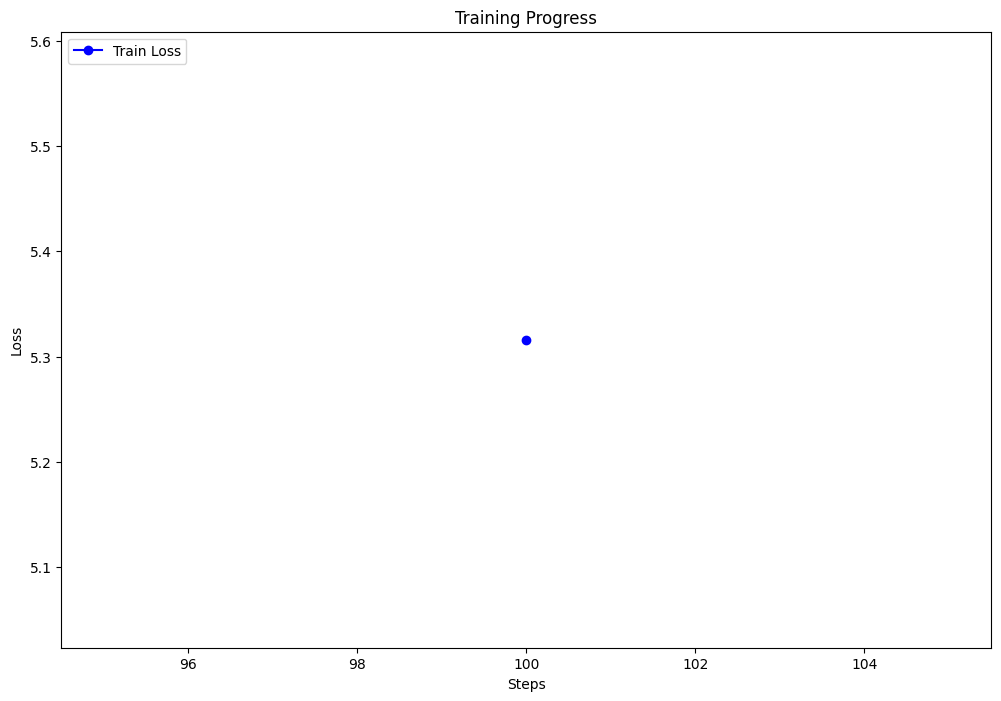

{'loss': 5.3161, 'grad_norm': 2.7367470264434814, 'learning_rate': 0.0001, 'epoch': 0.00511849311562676}
{'loss': 5.3161, 'grad_norm': 2.7367470264434814, 'learning_rate': 0.0001, 'epoch': 0.01}


  0%|          | 0/1222 [00:00<?, ?it/s]

In [151]:
trainer.train()
loss_callback.plot_losses()


In [107]:
# Save the model
model.save_pretrained("./checkpoints/checkpoint-final")
print("Model saved!")

Model saved!


## Evaluation


In [132]:
import numpy as np
import torch
from transformers import Trainer, TrainingArguments

# Set up evaluation arguments
eval_args = TrainingArguments(
    output_dir="./checkpoints", do_train=False, do_eval=True, per_device_eval_batch_size=100, dataloader_drop_last=False
)

# Create a Trainer instance for evaluation
eval_trainer = Trainer(model=model, args=eval_args, eval_dataset=test_tokenized, data_collator=data_collator)

# Run evaluation
eval_results = eval_trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Calculate perplexity
perplexity = np.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity}")

# Generate some text as a sanity check
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
_ = model.eval()


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluation Results:
eval_loss: 0.48569685220718384
eval_model_preparation_time: 0.0005
eval_runtime: 1.6823
eval_samples_per_second: 22.588
eval_steps_per_second: 0.594
Perplexity: 1.6253072132277402


In [133]:
import torch
from tqdm.auto import tqdm

from storm_ml.utils import FieldToken


def truncate(tensor, truncate_id):
    index = (tensor == truncate_id).nonzero()
    if index.numel() > 0:
        return tensor[: index[-1] + 1]
    return tensor


def predict_label(input_ids: torch.Tensor, model):
    target_token_id = encoder.encode(FieldToken(TARGET_FIELD))
    trunc_ids = truncate(input_ids, target_token_id).view(1, -1).to(model.device)

    # Assuming trunc_ids is your truncated tensor of input IDs
    attention_mask = torch.ones_like(trunc_ids).to(model.device)

    with torch.no_grad():
        output = model.generate(trunc_ids, attention_mask=attention_mask, max_new_tokens=1)

    pred = encoder.decode(output[0, -1])
    return pred


predictions = [predict_label(doc, model) for doc in tqdm(test_tokenized["input_ids"])]


  0%|          | 0/38 [00:00<?, ?it/s]

In [134]:
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

predictions_int = [encoder.encode(pred) for pred in predictions]
references_int = [encoder.encode(ref) for ref in test_tokenized["target"]]

# Compute metrics
results = accuracy_metric.compute(predictions=predictions_int, references=references_int)

print("results: ", results)

results:  {'accuracy': 0.8157894736842105}
